In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.tree import plot_tree

plt.rcParams['figure.figsize'] = (25,5)

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [99]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df.sample(10)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
76,24/11/2020 11:43:34,30.0,Male,Munich,DevOps,8,2,Middle,NaN,NaN,70200.0,75000,30,Full-time employee,Unlimited contract,English,1000+,Product
697,25/11/2020 20:47:48,35.0,Male,Munich,DevOps,17,5,Lead,Kubrrnetes,"R, AWS, Google Cloud, Kubernetes, Docker",72000.0,8000,30,Full-time employee,Unlimited contract,English,1000+,Consulting / Agency
387,24/11/2020 18:59:38,24.0,Male,Munich,Software Engineer,3,2,Middle,Java/C++,"Python, C/C++, Javascript / Typescript, Java /...",77600.0,43500,30,Full-time employee,Unlimited contract,English,1000+,Product
112,24/11/2020 11:56:05,33.0,Male,Berlin,Backend Developer,12,6,Lead,PHP,"Javascript / Typescript, SQL, AWS, Docker",65000.0,NaN,27,Full-time employee,Unlimited contract,English,101-1000,Product
551,25/11/2020 11:51:49,31.0,Male,Munich,Frontend Developer,8,3,Senior,"Typescript, Web apps",Javascript / Typescript,79000.0,5000,30,Full-time employee,Unlimited contract,English,1000+,Product
117,24/11/2020 11:57:53,30.0,Female,Berlin,Software Engineer,8,2,Senior,"Scala, React.js","Javascript / Typescript, SQL, AWS, Kubernetes,...",75000.0,NaN,35,Full-time employee,Unlimited contract,English,101-1000,Product
465,24/11/2020 23:44:21,40.0,Male,Stuttgart,Software Engineer,14,14,Senior,C,C/C++,95000.0,NaN,NaN,Full-time employee,Unlimited contract,German,1000+,Product
934,30/11/2020 11:34:22,26.0,Male,Berlin,Backend Developer,6,3,Senior,Go,"PHP, Go",70000.0,71000,27,Full-time employee,Unlimited contract,English,1000+,Product
175,24/11/2020 12:28:14,33.0,Male,Berlin,Backend Developer,5,2,Middle,Java,NaN,66000.0,70000,30,Full-time employee,Unlimited contract,English,101-1000,Product
65,24/11/2020 11:38:14,38.0,Male,Stuttgart,Hardware Engineer,15,5,Lead,Hardware,NaN,83000.0,NaN,30,Full-time employee,Unlimited contract,English,1000+,Product


In [101]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [102]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product


In [ ]:
df_tmp = df[df.groupby("Other technologies/programming languages you use often")["Other technologies/programming languages you use often"].transform('size') > 2]
df_tmp = df_tmp[df_tmp["target"] < 250000]

plt.figure(figsize=(45,5))
ax = sns.countplot(x="Other technologies/programming languages you use often", data=df_tmp)
ax.axhline(10)
ax.tick_params(axis='x', rotation=90)

## Construct a Target:

<AxesSubplot:xlabel='target', ylabel='Count'>

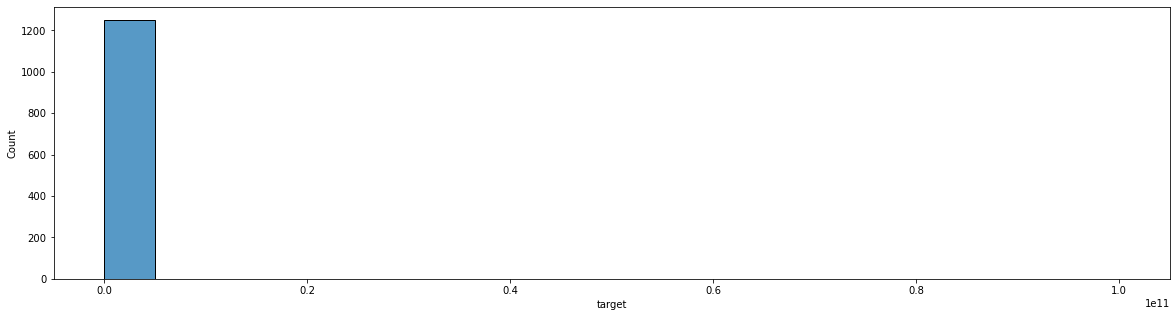

In [104]:
plt.figure(figsize=(20,5))
sns.histplot(df["target"], bins=20)

In [105]:
df["target"].describe()

count    1.253000e+03
mean     8.428361e+07
std      2.829182e+09
min      1.000100e+04
25%      6.000000e+04
50%      7.400000e+04
75%      9.100000e+04
max      1.000000e+11
Name: target, dtype: float64

In [106]:
df["target"].median()

74000.0

In [107]:
df = df[df["target"] < 200000]

<AxesSubplot:xlabel='target', ylabel='Count'>

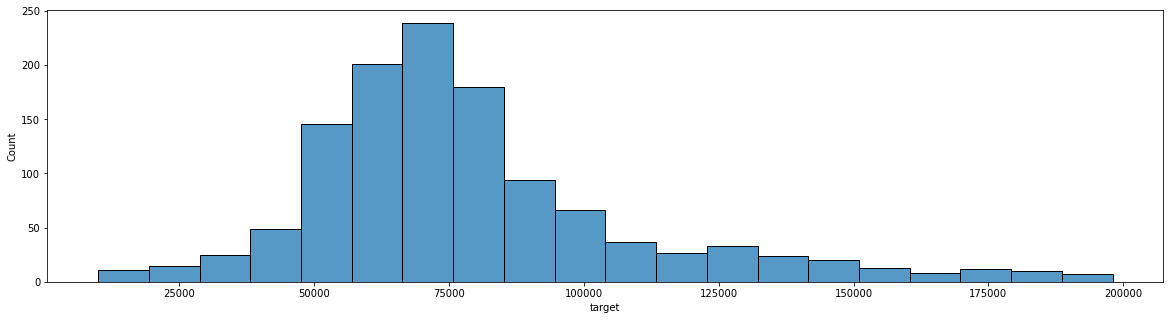

In [108]:
plt.figure(figsize=(20,5))
sns.histplot(df["target"], bins=20)

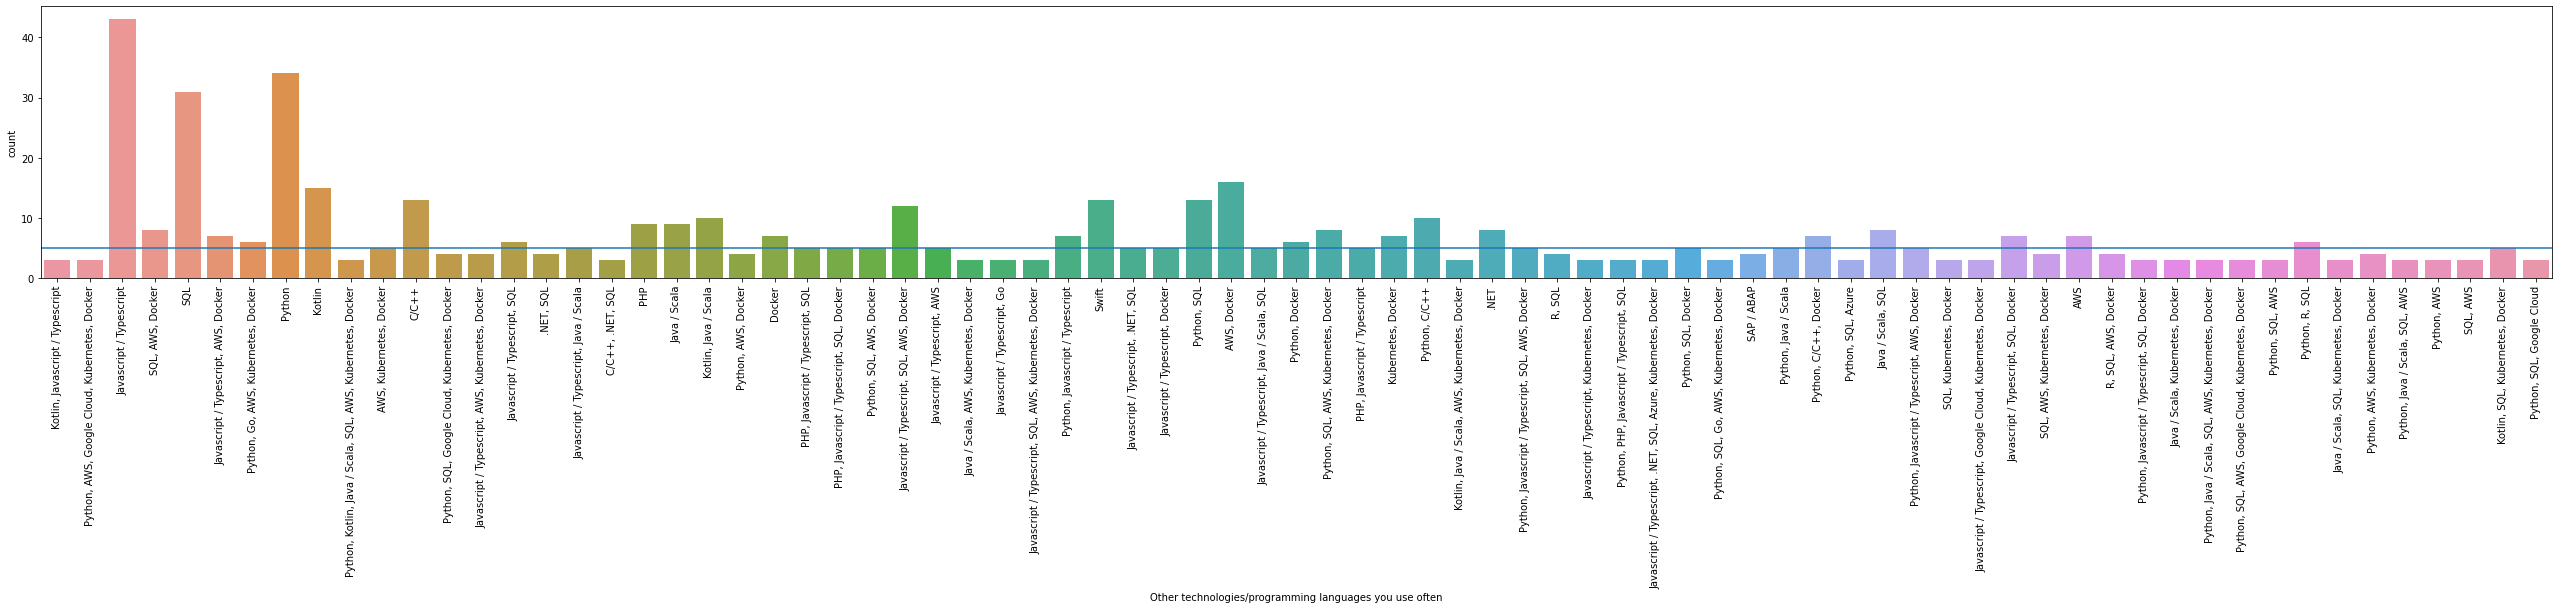

In [144]:
df_tmp = df[df.groupby("Other technologies/programming languages you use often")["Other technologies/programming languages you use often"].transform('size') > 2]
df_tmp = df_tmp[df_tmp["target"] < 200000]

plt.figure(figsize=(45,5))
ax = sns.countplot(x="Other technologies/programming languages you use often", data=df_tmp)
ax.axhline(5)
ax.tick_params(axis='x', rotation=90)

### Checking data type for each columns:

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1192 non-null   float64
 1   Gender                                                  1209 non-null   object 
 2   City                                                    1217 non-null   object 
 3   Position                                                1212 non-null   object 
 4   Total years of experience                               1202 non-null   object 
 5   Years of experience in Germany                          1187 non-null   object 
 6   Seniority level                                         1206 non-null   object 
 7   Your main technology / programming language             1095 non-null   object 
 8   Other technologies/programming languag

## Prepare the value for Categorical columns:

In [110]:
def replace_low_freq(d, col, threshold=10, replacement="other"):
    value_counts = d[col].value_counts() 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

### City:

In [111]:
df["City"].value_counts()

Berlin         660
Munich         228
Frankfurt       43
Hamburg         40
Stuttgart       26
              ... 
Wroclaw          1
Kempten          1
Salzburg         1
Bodensee         1
Saarbrücken      1
Name: City, Length: 117, dtype: int64

In [112]:
df["City"] = replace_low_freq(df, "City", 10, "Other")
df["City"].value_counts()

Berlin       660
Munich       228
Other        201
Frankfurt     43
Hamburg       40
Stuttgart     26
Cologne       19
Name: City, dtype: int64

### Gender:

In [113]:
df["Gender"] = replace_low_freq(df, "Gender", 10, "Other")
df["Gender"].value_counts()

Male      1016
Female     191
Other        2
Name: Gender, dtype: int64

### Position:

In [114]:
df.rename(columns={"Position ":"Position"}, inplace=True)

In [115]:
df["Position"] = replace_low_freq(df, "Position", 10, "Other")
df["Position"].value_counts()

Software Engineer     377
Other                 176
Backend Developer     171
Data Scientist        105
Frontend Developer     88
QA Engineer            71
DevOps                 55
Mobile Developer       52
ML Engineer            40
Product Manager        38
Data Engineer          23
Designer (UI/UX)       16
Name: Position, dtype: int64

### Seniority level:

In [116]:
df["Seniority level"] = replace_low_freq(df, "Seniority level", 10, "Other")
df["Seniority level"].value_counts()

Senior    553
Middle    365
Lead      154
Junior     78
Head       38
Other      18
Name: Seniority level, dtype: int64

### Main programing language:

In [117]:
df["Your main technology / programming language"] = replace_low_freq(df, "Your main technology / programming language", 20, "Other")
df["Your main technology / programming language"].replace({"Javascript": "JavaScript", "Python ":"Python"}, inplace=True)
df["Your main technology / programming language"].value_counts()

Other         455
Java          181
Python        158
JavaScript     65
PHP            55
C++            36
C#             29
python         26
Go             23
Scala          23
Swift          23
Kotlin         21
Name: Your main technology / programming language, dtype: int64

### Employment status:

In [118]:
df["Employment status"] = replace_low_freq(df, "Employment status", 10, "Other")
df["Employment status"].value_counts()


Full-time employee            1159
Self-employed (freelancer)      24
Other                           18
Name: Employment status, dtype: int64

### Сontract duration:

In [119]:
df.rename(columns={"Сontract duration":"Contract duration"}, inplace=True)

In [120]:
df["Contract duration"] = replace_low_freq(df, "Contract duration", 10, "Other")
df["Contract duration"].value_counts()
 

Unlimited contract    1131
Temporary contract      62
Name: Contract duration, dtype: int64

### Main language at work:

In [121]:
df["Main language at work"] = replace_low_freq(df, "Main language at work", 10, "Other")
df["Main language at work"].value_counts()

English    987
German     184
Other       19
Russian     12
Name: Main language at work, dtype: int64

### Company Type:

In [122]:
df["Company type"] = replace_low_freq(df, "Company type", 10, "Other")
df["Company type"].value_counts()

Product                739
Startup                245
Consulting / Agency    140
Other                   70
Name: Company type, dtype: int64

### Company Size:

In [123]:
df["Company size"].value_counts()

1000+       433
101-1000    394
11-50       171
51-100      145
up to 10     58
Name: Company size, dtype: int64

### Creat a list for Categorical columns:

In [124]:
cat_list = ["Gender", "City", "Position", "Seniority level", "Your main technology / programming language", "Employment status", "Contract duration", "Main language at work", "Company size", "Company type"]
cat_list

['Gender',
 'City',
 'Position',
 'Seniority level',
 'Your main technology / programming language',
 'Employment status',
 'Contract duration',
 'Main language at work',
 'Company size',
 'Company type']

In [125]:
for col in cat_list:
    df[col] = df[col].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   Age                                                     1192 non-null   float64 
 1   Gender                                                  1209 non-null   category
 2   City                                                    1217 non-null   category
 3   Position                                                1212 non-null   category
 4   Total years of experience                               1202 non-null   object  
 5   Years of experience in Germany                          1187 non-null   object  
 6   Seniority level                                         1206 non-null   category
 7   Your main technology / programming language             1095 non-null   category
 8   Other technologies/programmi

## Prepare the value for Numerical columns:

### Age:

In [126]:
df["Age"].describe()

count    1192.000000
mean       32.410235
std         5.594647
min        21.000000
25%        29.000000
50%        32.000000
75%        35.000000
max        69.000000
Name: Age, dtype: float64

In [127]:
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["Age"] = df["Age"].fillna(df["Age"].mean())
df["Age"]

0       26.0
1       26.0
3       28.0
4       37.0
5       32.0
        ... 
1248    31.0
1249    33.0
1250    39.0
1251    26.0
1252    26.0
Name: Age, Length: 1217, dtype: float64

### Total years of experience:

In [128]:
df["Total years of experience"].replace(",",".",regex=True, inplace=True)
df["Total years of experience"] = pd.to_numeric(df["Total years of experience"], errors="coerce")
df["Total years of experience"] = df["Total years of experience"].fillna(df["Total years of experience"].median())
df["Total years of experience"]

0        5.0
1        7.0
3        4.0
4       17.0
5        5.0
        ... 
1248     9.0
1249    10.0
1250    15.0
1251     7.0
1252     2.0
Name: Total years of experience, Length: 1217, dtype: float64

### Years of experience in Germany:

In [129]:
df["Years of experience in Germany"].replace(",",".",regex=True, inplace=True)
df["Years of experience in Germany"] = pd.to_numeric(df["Years of experience in Germany"], errors="coerce")
df["Years of experience in Germany"] = df["Years of experience in Germany"].fillna(df["Years of experience in Germany"].median())
df["Years of experience in Germany"]

0       3.0
1       4.0
3       1.0
4       6.0
5       1.0
       ... 
1248    5.0
1249    1.5
1250    2.0
1251    7.0
1252    2.0
Name: Years of experience in Germany, Length: 1217, dtype: float64

### Number of vacation days:

In [130]:
df["Number of vacation days"].replace(",",".",regex=True, inplace=True)
df["Number of vacation days"] = pd.to_numeric(df["Number of vacation days"], errors="coerce")
df["Number of vacation days"] = df["Number of vacation days"].fillna(df["Number of vacation days"].median())
df["Number of vacation days"]


0       30.0
1       28.0
3       24.0
4       29.0
5       30.0
        ... 
1248    26.0
1249    28.0
1250    28.0
1251    27.0
1252    30.0
Name: Number of vacation days, Length: 1217, dtype: float64

### Creat a list for Numerical columns:

In [131]:
num_list = ["Age", "Total years of experience", "Years of experience in Germany", "Number of vacation days"]

for y in num_list:
    df[y] = df[y].astype("float")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   Age                                                     1217 non-null   float64 
 1   Gender                                                  1209 non-null   category
 2   City                                                    1217 non-null   category
 3   Position                                                1212 non-null   category
 4   Total years of experience                               1217 non-null   float64 
 5   Years of experience in Germany                          1217 non-null   float64 
 6   Seniority level                                         1206 non-null   category
 7   Your main technology / programming language             1095 non-null   category
 8   Other technologies/programmi

### Get a new datafram with the cat_list, num_list, and target:

In [136]:
df1 = cat_list + num_list + ["target"]
df2 = df.drop(columns=[x for x in df if x not in df1])
df2.head()

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Number of vacation days,Employment status,Contract duration,Main language at work,Company size,Company type,target
0,26.0,Male,Munich,Software Engineer,5.0,3.0,Senior,Other,30.0,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,26.0,Male,Berlin,Backend Developer,7.0,4.0,Senior,Other,28.0,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0
3,28.0,Male,Berlin,Frontend Developer,4.0,1.0,Junior,JavaScript,24.0,Full-time employee,Unlimited contract,English,51-100,Startup,54000.0
4,37.0,Male,Berlin,Backend Developer,17.0,6.0,Senior,Other,29.0,Full-time employee,Unlimited contract,English,101-1000,Product,62000.0
5,32.0,Male,Berlin,DevOps,5.0,1.0,Senior,Other,30.0,Full-time employee,Unlimited contract,English,11-50,Startup,81000.0


## Prediction and Modeling:

In [137]:
# Pipline and Model:

categorical_features = cat_list
categorical_transformer = Pipeline(steps=[
        ("encode", OneHotEncoder(handle_unknown="ignore"))
    ])

numeric_features = num_list
numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])

preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ], remainder="drop")

#Split data
y = df2["target"]
X = df2.drop(columns={"target"})
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape)

# Model
model = RandomForestRegressor(n_jobs=-1, n_estimators=500)

#Build pipeline
pipeline_steps = [('pre', preprocessor),
                ('model', model)
                ]
pipe = Pipeline(pipeline_steps)
pipe.fit(X_train, y_train)

print("Depth:", pipe.named_steps['model'])
print("Train R2:", pipe.score(X_train, y_train))
print("Train RMSE:", mean_squared_error(y_train, pipe.predict(X_train), squared=False))
print("Test R2:", pipe.score(X_test, y_test))
print("Test RMSE:", mean_squared_error(y_test, pipe.predict(X_test), squared=False))


(912, 14)
Depth: RandomForestRegressor(n_estimators=500, n_jobs=-1)
Train R2: 0.8859514366073585
Train RMSE: 10436.147738525913
Test R2: 0.20491276712880468
Test RMSE: 28639.201596186533


#### The model has good performance on the training set with an R2 score of 0.89 and an RMSE of 10436. However, the model's performance on the test set is not as good, with an R2 score of 0.20 and an RMSE of 28639. The reason could be the model is overfitting to the training data and not generalizing well to new data.

### Adding Feature selection:

In [143]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=3,
    scoring="r2",
    min_features_to_select=3,
)
pipeline_steps2 = [("pre", preprocessor),
                ("feature selection", rfecv),
                ("model", model)
                ]
pipe2 = Pipeline(pipeline_steps2)
pipe2.fit(X_train, y_train)

print("Depth:", pipe2.named_steps["model"])
print("Features:", rfecv.n_features_, rfecv.n_features_in_)
print("Train R2:", pipe2.score(X_train, y_train))
print("Train RMSE:", mean_squared_error(y_train, pipe2.predict(X_train), squared=False))
print("Test R2:", pipe2.score(X_test, y_test))
print("Test RMSE:", mean_squared_error(y_test, pipe2.predict(X_test), squared=False))

Depth: RandomForestRegressor(n_estimators=500, n_jobs=-1)
Features: 47 71
Train R2: 0.8856913056463172
Train RMSE: 10448.04275416818
Test R2: 0.190334800262686
Test RMSE: 28900.55967936397


### Adding Grid search:

In [141]:
grid_ = {
    "model__max_depth": [4,5,6,7],
    "model__n_estimators": [75,100,125,150,175,200,300],
    "model__max_features":["auto", "sqrt", "log2"]
        }

clf = GridSearchCV(pipe, param_grid=grid_, cv=3, n_jobs=-1)

clf.fit(X_train, y_train.ravel())
best = clf.best_estimator_

print("Test R2:", best.score(X_test, y_test))
print("Test RMSE:", mean_squared_error(y_test, best.predict(X_test), squared=False))
print(best)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

Test R2: 0.23814389210404618
Test RMSE: 28034.317879690865
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age',
                                                   'Total years of experience',
                                                   'Years of experience in '
                                                   'Germany',
                                                   'Number of vacation days']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                          

In [142]:
# Model
model3 = RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=175,
                                       n_jobs=-1)


#Build pipeline
pipeline_steps3 = [("pre", preprocessor),
                ("model", model3)
                ]
pipe3 = Pipeline(pipeline_steps3)
pipe3.fit(X_train, y_train)

print("Depth:", pipe3.named_steps["model"])
print("Train R2:", pipe3.score(X_train, y_train))
print("Train RMSE:", mean_squared_error(y_train, pipe3.predict(X_train), squared=False))
print("Test R2:", pipe3.score(X_test, y_test))
print("Test RMSE:", mean_squared_error(y_test, pipe3.predict(X_test), squared=False))

Depth: RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=175,
                      n_jobs=-1)
Train R2: 0.4264515866054793
Train RMSE: 23403.47516909073
Test R2: 0.24109057895651598
Test RMSE: 27980.050159377377


# Answers and Explainations

## Results

#### The model used is Random Forest Regression. Train R2 is 0.89. Train RMSE is 10436. Test R2 is 0.20. Test RMSE is 28639. 
#### Feature selection: RFECV. Test R2 did not get better. Train R2: 0.89. Train RMSE is 10448. Test R2 is 0.19. Test RMSE is 28900. The reason could be the features removed may contain important information that the model needs to make accurate result. Or the features removed could impact the correlation to other features. Overfitting is still a issue. The features selection method is not optical for this modeling. 
#### Grid search:
#### Hyperparameter used are:
"model__max_depth": [4,5,6,7]

"model__n_estimators": [75,100,125,150,175,200,300]

"model__max_features":["auto", "sqrt", "log2"]
#### Test R2 increased to 0.24 and RMSE is 27980. It is slightly better than the orginal model. However the Test R2 is still lower than Train R2. The reason could be the model is still overfitting to the training data and not generalizing well to test data. Overfitting is still happening. The dataset might be very complex and data cleaning is not efficient enough. This model is not good enough to predict the target. It is also necessary to try other models for more accurate result.

